# How to work with Weather Extremes Digital Twin data on Earth Data Hub

***
This notebook will provide you guidance on how to access and use the `s3://destine-extreme-dt/destine-extreme-dt-sample.zarr` datset on Earth Data Hub.

Our goal is to plot the surface presssure in central Europe on January 10 2024.
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* plot the results

## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [1]:
import xarray as xr

# your `~/.netrc` file MUST contain your credentials for earthdatahub.com
#
# machine earthdatahub.com
#   login {your_username}
#   password {your_password}

ds = xr.open_dataset(
    "https://earthdatahub.com/stores/destine-extreme-dt/destine-extreme-dt-sample.zarr",
    chunks={},
    engine="zarr",
    storage_options={"client_kwargs": {"trust_env": True}},
)
ds

<xarray.Dataset>
Dimensions:     (latitude: 181, longitude: 360)
Coordinates:
  * latitude    (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    step        timedelta64[ns] ...
    surface     float64 ...
    time        datetime64[ns] ...
    valid_time  datetime64[ns] ...
Data variables:
    sp          (latitude, longitude) float32 dask.array<chunksize=(64, 128), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          0
    history:                 2024-02-19T16:20 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## Surface pressure over central Europe on the first of March 1990

### 1. Data selection

First, we select the surface pressure variable from the climate dt sample dataset. Then, we perform a geographical selection corresponding to the central Europe area. This reduces the amount of data that will be downloaded from EDH.

In [2]:
sp = ds.sp
sp_central_europe = sp.sel(**{"latitude": slice(55, 45), "longitude": slice(2, 24)})
sp_central_europe

<xarray.DataArray 'sp' (latitude: 11, longitude: 23)>
dask.array<getitem, shape=(11, 23), dtype=float32, chunksize=(11, 23), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 55.0 54.0 53.0 52.0 ... 48.0 47.0 46.0 45.0
  * longitude   (longitude) float64 2.0 3.0 4.0 5.0 6.0 ... 21.0 22.0 23.0 24.0
    step        timedelta64[ns] ...
    surface     float64 ...
    time        datetime64[ns] ...
    valid_time  datetime64[ns] ...
Attributes: (12/29)
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              surface_air_pressure
    GRIB_cfVarName:                           sp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_stepUnits:                           1
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               Pa
    long_name:                                Surface pressure
    standard_name:                            surface_air_pressure
    units:                                    Pa

At this point, no data has been downloaded yet, nor loaded in memory. However, the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory. 

We can measure the time it takes:

In [3]:
%%time

sp_central_europe = sp_central_europe.compute()

CPU times: user 153 ms, sys: 35.6 ms, total: 189 ms
Wall time: 1.53 s


The selection was small, this didn't take long!

### 3. Visualization

We can plot the surface presssure in central Europe on January 10 2024:

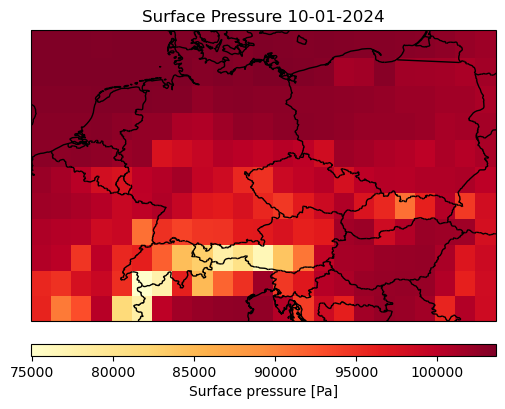

In [4]:
from cartopy import crs, feature
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": crs.Miller()})
sp_central_europe.plot(
    ax=ax, 
    cmap="YlOrRd", 
    transform=crs.PlateCarree(), 
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "Surface pressure [Pa]"},
)
ax.coastlines()
ax.add_feature(feature.BORDERS)
ax.set_title("Surface Pressure 10-01-2024")
plt.show()